Time processing on CPU: 0.9385004043579102s
Block size: 64, Time processing on GPU: 0.10533261299133301
Block size: 128, Time processing on GPU: 0.00019812583923339844
Block size: 256, Time processing on GPU: 0.00016808509826660156
Block size: 512, Time processing on GPU: 0.00018453598022460938
Block size: 1024, Time processing on GPU: 0.0001323223114013672


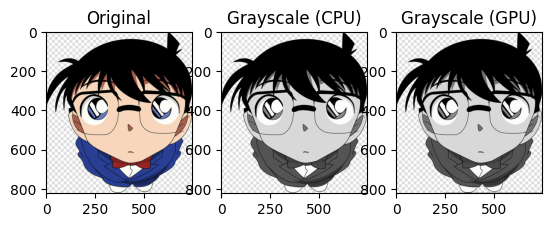

In [15]:
import numba
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from numba import jit
from matplotlib.image import imread
import time

# Load an image from a file
image_path = 'labwork3-original.jpg'
image = imread(image_path)
plt.subplot(131), plt.imshow(image), plt.title('Original')

# Flatten the image into a 1D array of RGB values
image_height = image.shape[0]
image_weight = image.shape[1]
pixel_count = image_height * image_weight
flattened_image = image.reshape(pixel_count, 3)

# grayscale using CPU
def grayscale_cpu(image):
    image_grayscale = np.zeros((image_height, image_weight), dtype=np.uint8)
    for i in range(image_height):
        for j in range(image_weight):
            image_grayscale[i, j] = (int(image[i][j][0]) + int(image[i][j][1]) + int(image[i][j][2])) /3
    return image_grayscale

# grayscale using GPU
@cuda.jit
def grayscale_gpu(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
    dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

# implement with CPU
start_time_cpu = time.time()
grayscale_cpu_image = grayscale_cpu(image)
time_cpu = time.time() - start_time_cpu
print(f"Time processing on CPU: {time_cpu}s")
plt.imsave('grayscale_cpu.jpg', grayscale_cpu_image, cmap='gray')
plt.subplot(132), plt.imshow(grayscale_cpu_image, cmap='gray'), plt.title('Grayscale (CPU)')

#implement with GPU
blockSizes = [64,128,256,512,1024]
times_gpu = []

for blockSize in blockSizes:
  gridSize = int(pixel_count/blockSize)
  devSrc = cuda.to_device(flattened_image)
  devDst = cuda.device_array((pixel_count, 3), np.uint8)

  start_time_gpu = time.time()
  grayscale_gpu_image = grayscale_gpu[gridSize, blockSize](devSrc, devDst)
  time_gpu = time.time() - start_time_gpu
  times_gpu.append(time_gpu)

  hostDst = devDst.copy_to_host()
  grayscale_gpu_image = np.reshape(hostDst, (image_height,image_weight ,3))
  plt.imsave('grayscale_gpu.jpg', grayscale_gpu_image, cmap='gray')
  plt.subplot(133), plt.imshow(grayscale_gpu_image, cmap='gray'), plt.title('Grayscale (GPU)')

for b, t in zip(blockSizes, times_gpu):
    print(f"Block size: {b}, Time processing on GPU: {t}")
plt.show()

# New Section